# Exploratory Data Analysis of RHoMIS Data

Exploring the RHoMIS data set, and other data sources it could potentially be merged with. Assessing coverage and potential for a farm-size mapping.

## Setup

In [1]:
# Setup
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from farmsize import data_prep, db_scan, mapping
from shapely.geometry import Point
import math

In [2]:
# Reading in Data Sources
country_mapping = data_prep.load_json("./data/country_mappings.json")

ipums_terra = mapping.read_geo_csv("./data/ipums/processed/ipums_terra_merged.csv")
ipums_terra = ipums_terra.loc[ipums_terra["iso_2"].isin(country_mapping["iso_2"]),:]
ipums_terra = ipums_terra.merge(country_mapping, left_on="iso_2", right_on="iso_2", how="left")

# Loading RHoMIS Indicators
indicator_data = pd.read_csv("./data/RHoMIS_Indicators.csv", encoding="latin")
countries_iso_2 = country_mapping["iso_2"].to_list()
indicator_data = data_prep.subset_data(indicator_data, complete_gps=True, countries=countries_iso_2) # Subsetting data bas

# World Shapefile
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

/home/lgorman/research/PhD/farm_size_analysis_python/farm_size_analysis_env/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3251: DtypeWarning: Columns (71) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
# Spatially joining the household survey, the world shapefile, and the ipums terra data
indicator_data["geometry"] = [Point(xy) for xy in zip(indicator_data["GPS_LON"], indicator_data["GPS_LAT"])]
geo_indicator = gpd.GeoDataFrame(indicator_data)
geo_indicator = geo_indicator.sjoin(world, how="left", op="within")
geo_indicator = geo_indicator.rename(columns={"index_right":"index_world_shapefile"})
geo_indicator = geo_indicator.sjoin(ipums_terra, how="left", op="within")
geo_indicator = geo_indicator.rename(columns={"index_right":"index_ipums_terra"})



/home/lgorman/research/PhD/farm_size_analysis_python/farm_size_analysis_env/lib/python3.8/site-packages/pandas/core/dtypes/cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
/home/lgorman/research/PhD/farm_size_analysis_python/farm_size_analysis_env/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3251: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/lgorman/research/PhD/farm_size_analysis_python/farm_size_analysis_env/lib/python3.8/site-packages/geopandas/geodataframe.py:1938: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: N

## Assessing Data Coverage

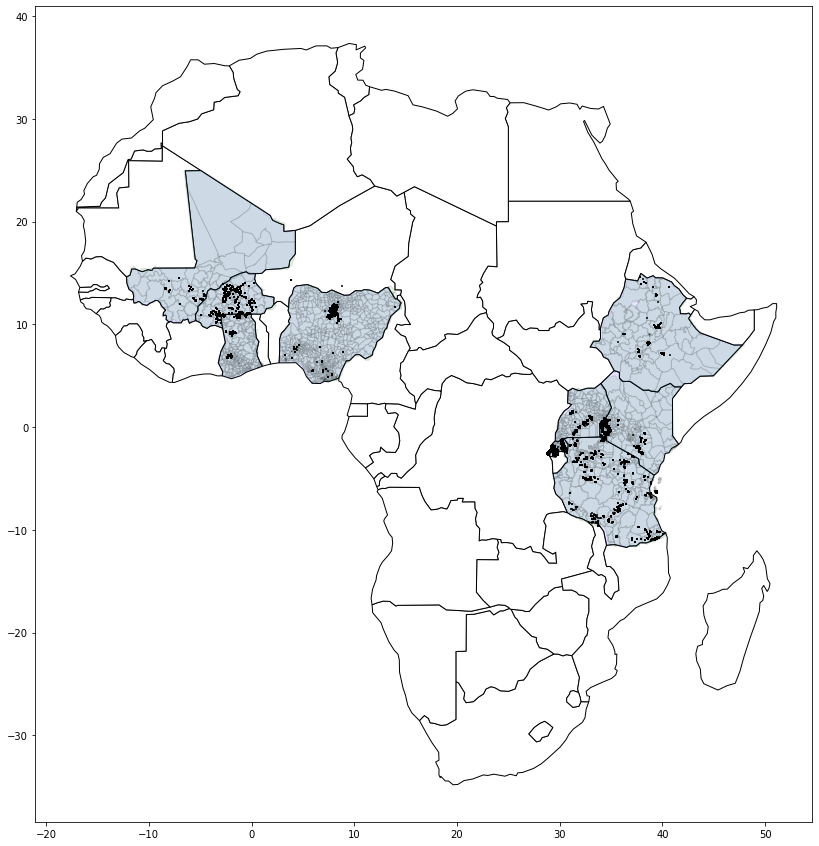

In [4]:
fig, ax =  plt.subplots(figsize=(15,15))
ax.set_aspect('equal')
#Plot map layer
world.loc[world["continent"]=="Africa",].plot(ax=ax,color="white", edgecolor="black")

world.loc[world["iso_a3"].isin(country_mapping["iso_3"]),].plot(ax=ax,color="blue", edgecolor="black", alpha=0.1)
ipums_terra .plot(ax=ax, color="green", edgecolor="black", alpha=0.1)
#Plot Points
geo_indicator.plot(ax=ax, marker=0, color='black', markersize=5)

fig.show()
fig.savefig('./outputs/exploratory/map.png')


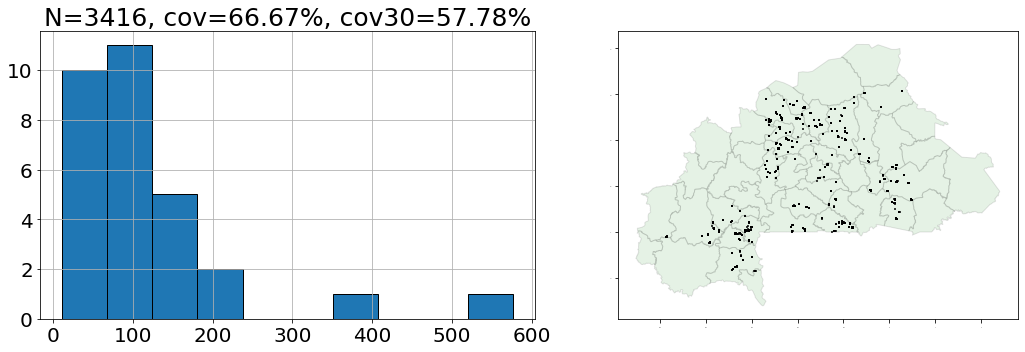

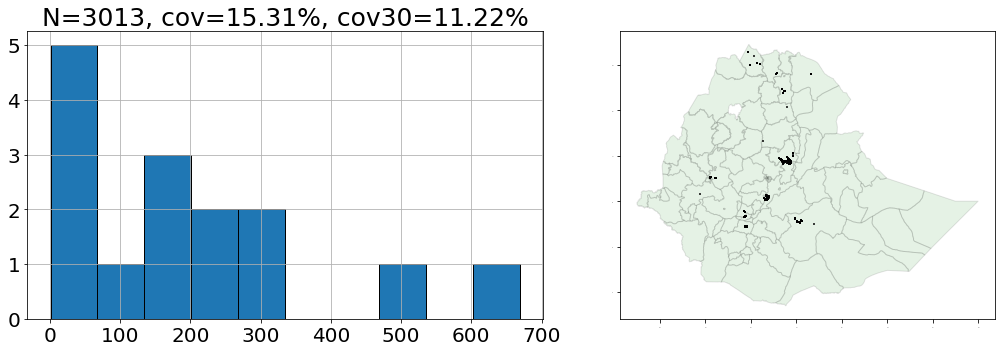

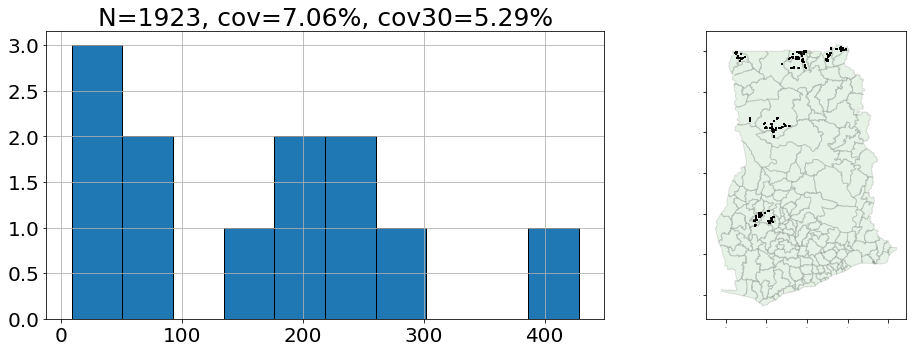

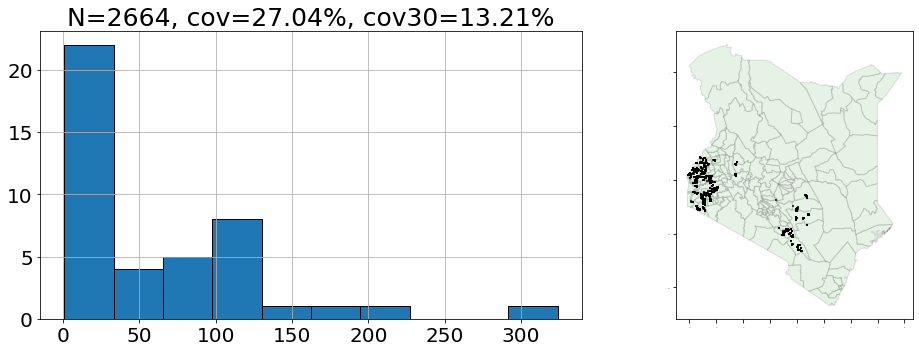

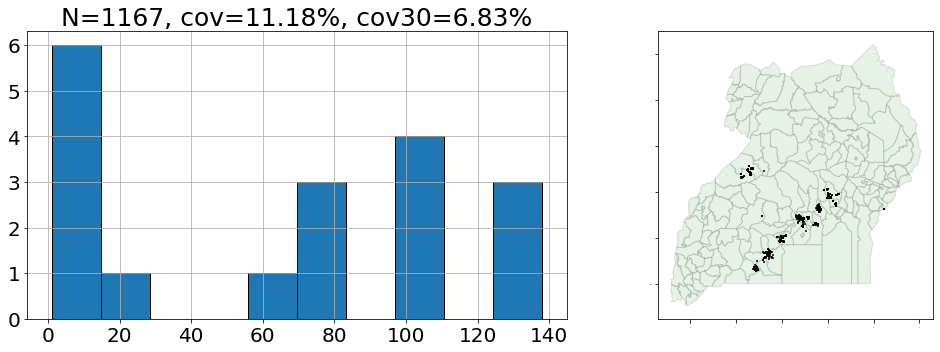

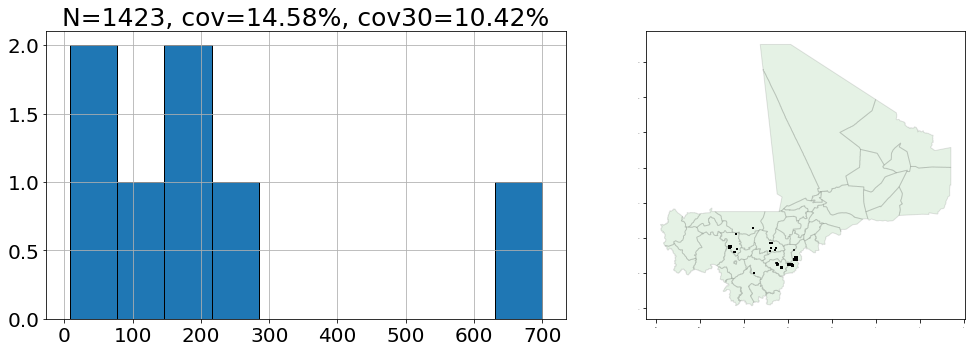

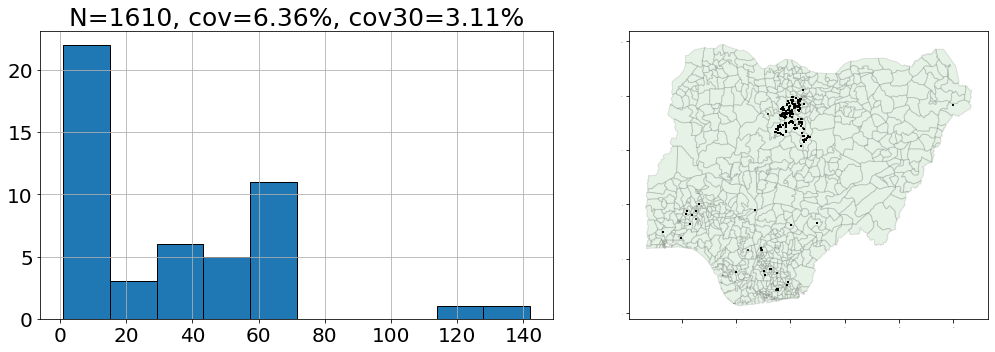

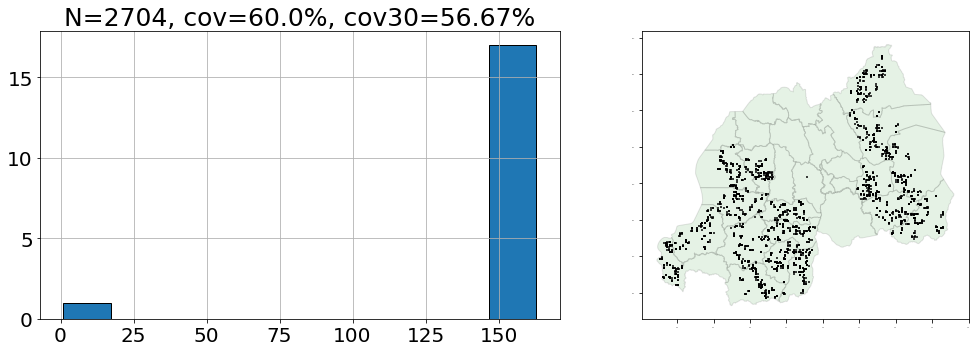

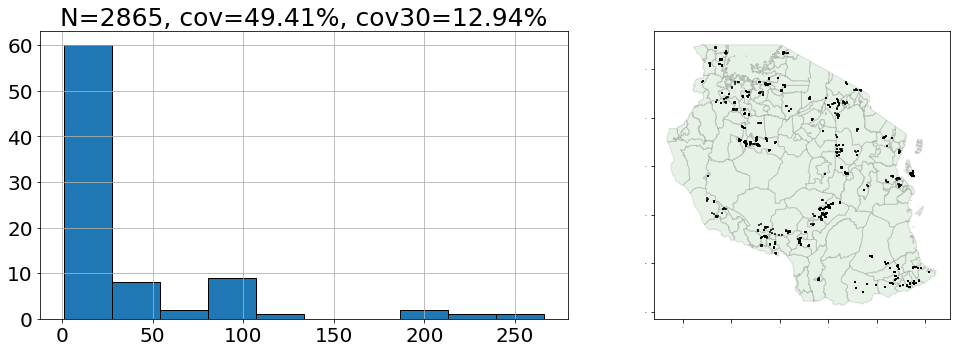

In [5]:
countries=geo_indicator.loc[geo_indicator["iso_3"].notna(),"iso_3"].unique()
# Counts per subnational unit
counts_per_subnational_unit = geo_indicator.groupby(["iso_3", "GEOID"]).size().reset_index(name="counts")
counts_per_subnational_unit.to_csv("./outputs/exploratory/hhs_per_unit.csv")

for country in countries:

    number_rhomis_subnational_region = len(geo_indicator.loc[geo_indicator["iso_3"]==country,"GEOID"].unique())
    number_total_subnational_region = len(ipums_terra.loc[ipums_terra["iso_3"]==country,"GEOID"].unique())

    counts_30 = geo_indicator.loc[geo_indicator["iso_3"]==country,"GEOID"].value_counts()
    counts_30 = counts_30[counts_30>30].count() 
    cov30 = str(round(100*counts_30/number_total_subnational_region,2))+"%"

    coverage = str(round(100*number_rhomis_subnational_region/number_total_subnational_region,2))+"%"
    N=str(geo_indicator.loc[geo_indicator["iso_3"]==country,:].shape[0])


    fig, ax = plt.subplots(1,2,figsize=(15,5))
    ax[0].set_title("N="+N+", cov="+coverage+", cov30="+cov30, fontsize=25)
    ax[0].tick_params(labelsize=20)
    ax[1].tick_params(labelsize=0)

    counts_per_subnational_unit.loc[counts_per_subnational_unit["iso_3"]==country,"counts"].hist(ax=ax[0], edgecolor="black")
    ipums_terra.loc[ipums_terra["iso_3"]==country,:].plot(ax=ax[1], color="green", edgecolor="black", alpha=0.1)
    geo_indicator.loc[geo_indicator["iso_3"]==country,:].plot(ax=ax[1], marker=0, color='black', markersize=5)
    fig.tight_layout()
    fig.savefig('./outputs/exploratory/map_per_country/'+country+'.png')


## Assessing Land Size Distributions

In [6]:
geo_indicator['less_than_two'] = geo_indicator["LandCultivated"]<2
geo_indicator['two_to_ten'] = (geo_indicator["LandCultivated"]>=2) & (geo_indicator["LandCultivated"]<10)
geo_indicator['ten_to_fifty'] = (geo_indicator["LandCultivated"]>=10) & (geo_indicator["LandCultivated"]<50)
geo_indicator['fifty_plus'] = (geo_indicator["LandCultivated"]>=50)
geo_indicator['all'] = (geo_indicator["LandCultivated"]>=0)



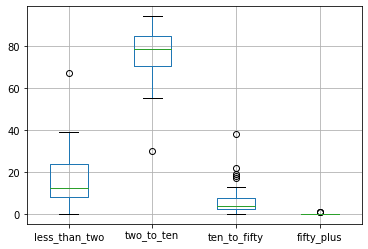

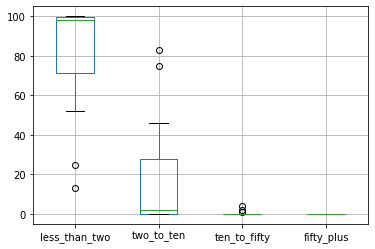

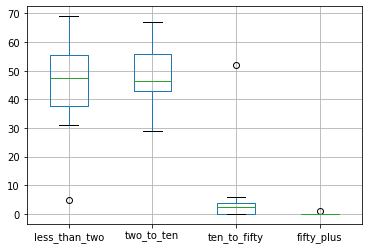

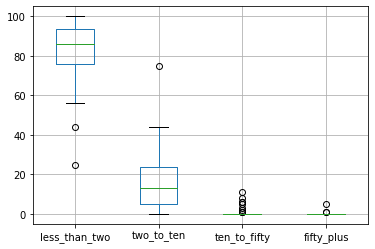

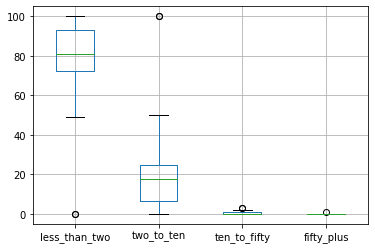

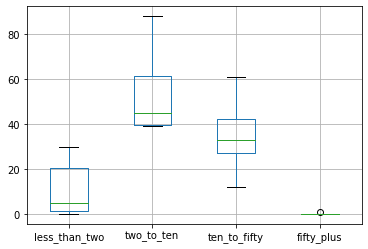

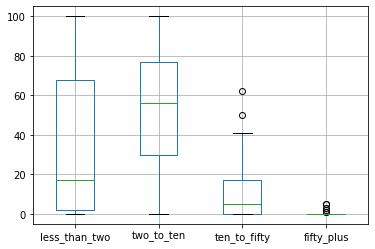

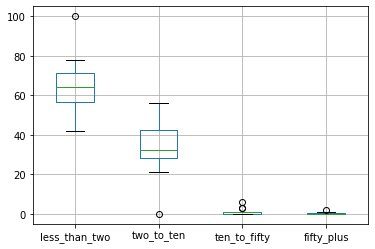

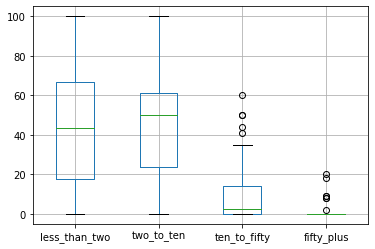

In [7]:

for country in countries:
    fig, ax = plt.subplots()
    aggregated_info = geo_indicator.loc[geo_indicator["iso_3"]==country,["GEOID","less_than_two", "two_to_ten", "ten_to_fifty", "fifty_plus","all"]].groupby("GEOID").sum()
    round(100*aggregated_info.loc[:,["less_than_two", "two_to_ten", "ten_to_fifty", "fifty_plus"]].div(aggregated_info["all"], axis=0)).boxplot(ax=ax)
    fig.show()


/tmp/ipykernel_673/3140563821.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  geo_indicator.loc[geo_indicator["LandCultivated"]<100,["iso_3","LandCultivated","GEOID"]].groupby("iso_3").boxplot(by="GEOID", ax=ax, showfliers=False)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


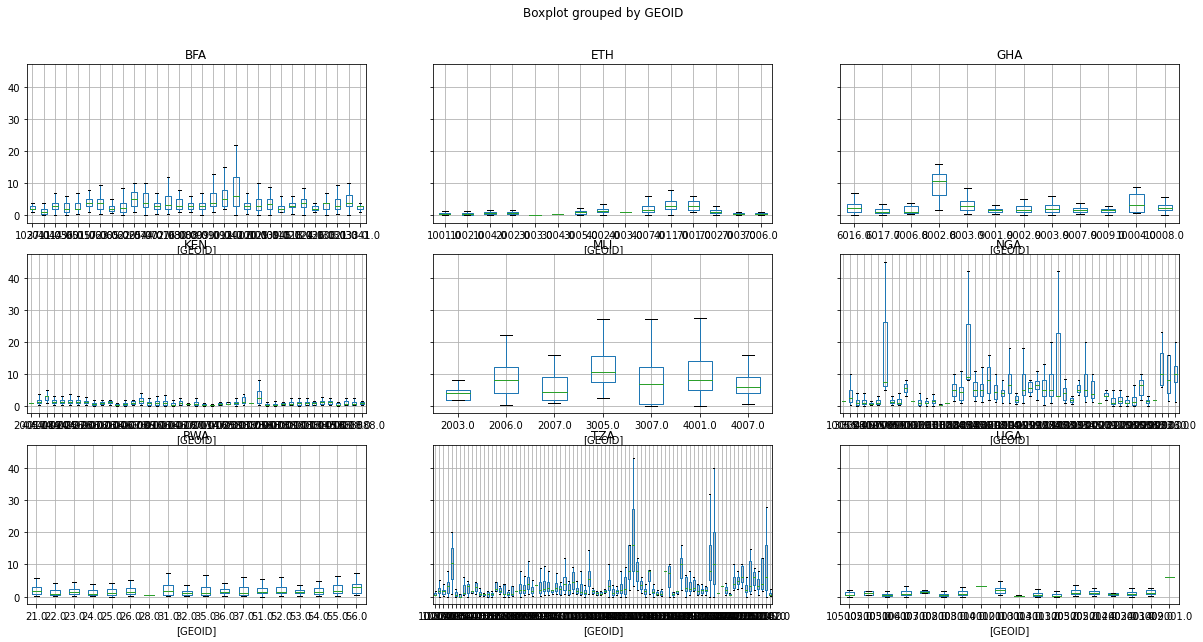

In [8]:
fig, ax = plt.subplots(figsize=(20,10))

geo_indicator.loc[geo_indicator["LandCultivated"]<100,["iso_3","LandCultivated","GEOID"]].groupby("iso_3").boxplot(by="GEOID", ax=ax, showfliers=False)
ax.set_xticklabels([])
ax.set_xlabel('')
ax.set_title('')
ax.set_xticks([])
ax.legend()

# Clustering Households Spatially

In [9]:
cluster_labels = db_scan.cluster_gps_points(indicator_data, "GPS_LON", "GPS_LAT", epsilon=0.1)

# Exploring LSMS Data

# Reading in LSMS prepped Data
Reading information from LSMS. All countries include GPS coordinates, except for Mali and Burkina Faso. In the case of Burkina, all of the districts were available in IPUMS terra, and related to subnational level 2. In the case of Mali, all of the districts were present, except for 443 households that were labelled as "commune", this was likely done in error. 

Seeing as there are so few RHoMIS points in Mali anyway, Mali LSMS was excluded.

In [10]:
burkina_lsms = data_prep.link_points_to_ipums_and_world("BFA","latitude","longitude","./data/lsms/LSMS_Burkina_landsizes.csv",ipums_terra,world)
ethiopia_lsms = data_prep.link_points_to_ipums_and_world("ETH","latitude","longitude","./data/lsms/LSMS_Ethiopia_landsizes.csv",ipums_terra,world)
malawi_lsms = data_prep.link_points_to_ipums_and_world("MWI","Latitude","Longitude","./data/lsms/LSMS_Malawi_2011_landsizes.csv",ipums_terra,world)
malawi_lsms.rename({"Latitude":"latitude", "Longitude":"longitude"}, inplace=True)
niger_lsms = data_prep.link_points_to_ipums_and_world("NER","latitude","longitude","./data/lsms/LSMS_Niger_landsizes.csv",ipums_terra,world)
nigeria_lsms = data_prep.link_points_to_ipums_and_world("NGA","Latitude","Longitude","./data/lsms/LSMS_Nigeria_landsizes.csv",ipums_terra,world)
nigeria_lsms.rename({"Latitude":"latitude", "Longitude":"longitude"}, inplace=True)

tanzania_lsms = data_prep.link_points_to_ipums_and_world("TZA","latitude","longitude","./data/lsms/LSMS_Tanzania_landsizes.csv",ipums_terra,world)
uganda_lsms = data_prep.link_points_to_ipums_and_world("UGA","Latitude","Longitude","./data/lsms/LSMS_Uganda_2012_landsizes.csv",ipums_terra,world)
uganda_lsms.rename({"Latitude":"latitude", "Longitude":"longitude"}, inplace=True)


lsms_data = pd.concat([burkina_lsms,ethiopia_lsms, malawi_lsms, niger_lsms, nigeria_lsms, tanzania_lsms, uganda_lsms])
lsms_data.to_csv("./data/lsms/lsms_all.csv",index=False)

/home/lgorman/research/PhD/farm_size_analysis_python/farm_size_analysis_env/lib/python3.8/site-packages/pandas/core/dtypes/cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
/home/lgorman/research/PhD/farm_size_analysis_python/farm_size_analysis_env/lib/python3.8/site-packages/pandas/core/dtypes/cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
/home/lgorman/research/PhD/farm_size_analysis_python/farm_size_analysis_env/lib/python3.8/site-packages/pandas/core/dtypes/cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array

In [11]:
lsms_data = mapping.read_geo_csv("./data/lsms/lsms_all.csv")


/tmp/ipykernel_673/2248269114.py:1: DtypeWarning: Columns (1,2,7,9,10,116,118,119,120,126,128,281,289,291) have mixed types.Specify dtype option on import or set low_memory=False.
  lsms_data = mapping.read_geo_csv("./data/lsms/lsms_all.csv")


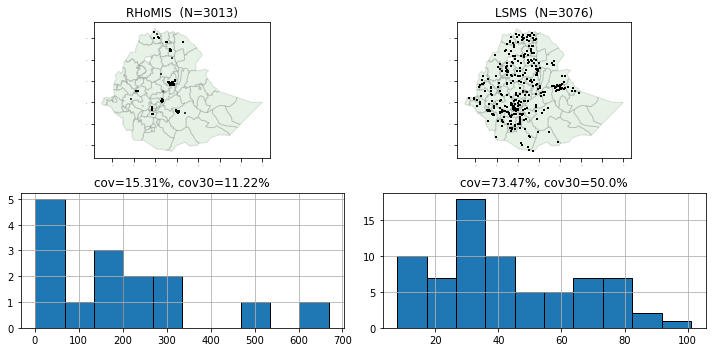

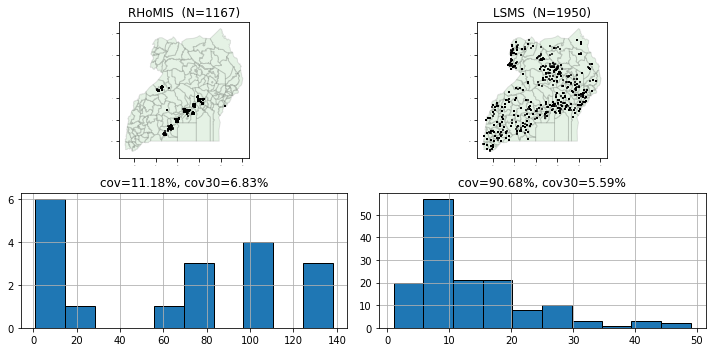

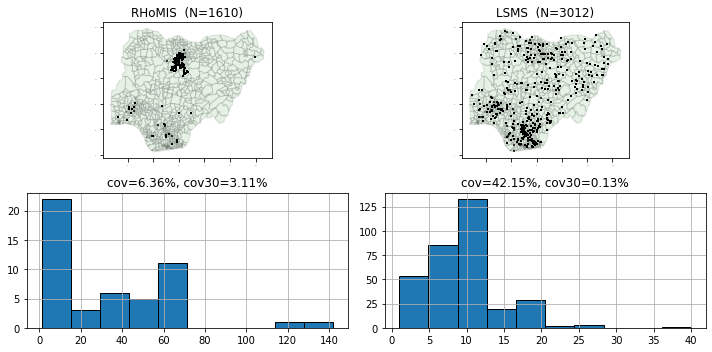

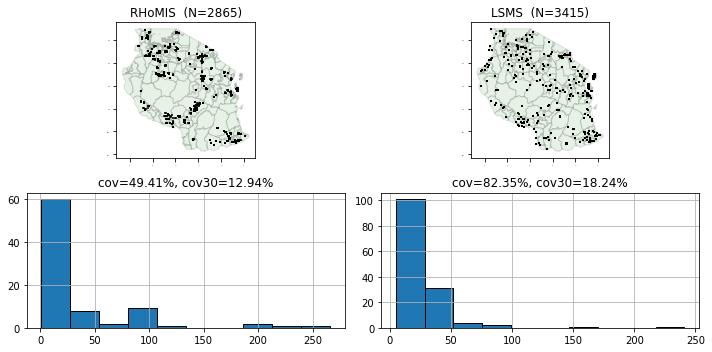

In [52]:
countries=geo_indicator.loc[geo_indicator["iso_3"].notna(),"iso_3"].unique()
# Counts per subnational unit
counts_per_subnational_unit = geo_indicator.groupby(["iso_3", "GEOID"]).size().reset_index(name="counts")
counts_per_subnational_unit_lsms = lsms_data.groupby(["iso_3", "GEOID"]).size().reset_index(name="counts")

counts_per_subnational_unit.to_csv("./outputs/exploratory/hhs_per_unit.csv")

for country in countries:
    
    number_rhomis_subnational_region = len(geo_indicator.loc[geo_indicator["iso_3"]==country,"GEOID"].unique())
    number_total_subnational_region = len(ipums_terra.loc[ipums_terra["iso_3"]==country,"GEOID"].unique())

    number_lsms_subnational_region = len(lsms_data.loc[lsms_data["iso_3"]==country,"GEOID"].unique())

    counts_30_rhomis = geo_indicator.loc[geo_indicator["iso_3"]==country,"GEOID"].value_counts()
    counts_30_rhomis = counts_30_rhomis[counts_30_rhomis>30].count() 
    cov30_rhomis = str(round(100*counts_30_rhomis/number_total_subnational_region,2))+"%"

    coverage_rhomis = str(round(100*number_rhomis_subnational_region/number_total_subnational_region,2))+"%"
    Nrhomis=str(geo_indicator.loc[geo_indicator["iso_3"]==country,:].shape[0])


    counts_30_lsms = lsms_data.loc[lsms_data["iso_3"]==country,"GEOID"].value_counts()
    counts_30_lsms = counts_30_lsms[counts_30_lsms>30].count() 
    cov30_lsms = str(round(100*counts_30_lsms/number_total_subnational_region,2))+"%"

    coverage_lsms = str(round(100*number_lsms_subnational_region/number_total_subnational_region,2))+"%"
    Nlsms=str(lsms_data.loc[lsms_data["iso_3"]==country,:].shape[0])

    

    if country not in ["BFA", "GHA", "KEN", "RWA","MLI"]:
    
        fig, ax = plt.subplots(2,2,figsize=(10,5))
        # ax[0].set_title("cov="+coverage_rhomis+", cov30="+cov30_rhomis+", N_rhomis="+Nrhomis, fontsize=25)
        # ax[0].tick_params(labelsize=20)
        plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)
        ax[0][0].tick_params(labelsize=0)
        ax[0][1].tick_params(labelsize=0)
        # plt.suptitle(country, fontsize=20)


        ax[0][0].title.set_text('RHoMIS '+' (N=' + Nrhomis+")")# seems to work too.
        ax[0][1].title.set_text('LSMS '+' (N=' + Nlsms+")")# seems to work too.

        ax[1][0].set_title("cov="+coverage_rhomis+", cov30="+cov30_rhomis)
        ax[1][1].set_title("cov="+coverage_lsms+", cov30="+cov30_lsms)



        counts_per_subnational_unit.loc[counts_per_subnational_unit["iso_3"]==country,"counts"].hist(ax=ax[1][0], edgecolor="black")
        counts_per_subnational_unit_lsms.loc[counts_per_subnational_unit_lsms["iso_3"]==country,"counts"].hist(ax=ax[1][1], edgecolor="black")

        
        ipums_terra.loc[ipums_terra["iso_3"]==country,:].plot(ax=ax[0][0], color="green", edgecolor="black", alpha=0.1)
        geo_indicator.loc[geo_indicator["iso_3"]==country,:].plot(ax=ax[0][0], marker=0, color='black', markersize=5)

        ipums_terra.loc[ipums_terra["iso_3"]==country,:].plot(ax=ax[0][1], color="green", edgecolor="black", alpha=0.1)
        lsms_data.loc[lsms_data["iso_3"]==country,:].plot(ax=ax[0][1], marker=0, color="black", markersize=5)
        fig.tight_layout()
        fig.savefig('./outputs/exploratory/map_per_country/'+country+'.png')

In [35]:
ax[0][0]

<AxesSubplot:>

In [22]:
country=""

number_rhomis_subnational_region = len(geo_indicator.loc[geo_indicator["iso_3"]==country,"GEOID"].unique())
number_total_subnational_region = len(ipums_terra.loc[ipums_terra["iso_3"]==country,"GEOID"].unique())

counts_30 = geo_indicator.loc[geo_indicator["iso_3"]==country,"GEOID"].value_counts()
counts_30 = counts_30[counts_30>30].count() 
cov30 = str(round(100*counts_30/number_total_subnational_region,2))+"%"

coverage = str(round(100*number_rhomis_subnational_region/number_total_subnational_region,2))+"%"
Nrhomis=str(geo_indicator.loc[geo_indicator["iso_3"]==country,:].shape[0])



    fig, ax = plt.subplots(1,3,figsize=(15,5))
    ax[0].set_title("cov="+coverage+", cov30="+cov30+", N_rhomis="+Nrhomis, fontsize=25)
    ax[0].tick_params(labelsize=20)
    ax[1].tick_params(labelsize=0)
    ax[2].tick_params(labelsize=0)
    counts_per_subnational_unit.loc[counts_per_subnational_unit["iso_3"]==country,"counts"].hist(ax=ax[0], edgecolor="black")
    ipums_terra.loc[ipums_terra["iso_3"]==country,:].plot(ax=ax[1], color="green", edgecolor="black", alpha=0.1)
    geo_indicator.loc[geo_indicator["iso_3"]==country,:].plot(ax=ax[1], marker=0, color='black', markersize=5)

    ipums_terra.loc[ipums_terra["iso_3"]==country,:].plot(ax=ax[2], color="green", edgecolor="black", alpha=0.1)
    lsms_data.loc[lsms_data["iso_3"]==country,:].plot(ax=ax[2], marker=0, color="black", markersize=5)
    # fig.tight_layout()
    fig.savefig('./outputs/exploratory/map_per_country/'+country+'.png')

/tmp/ipykernel_673/4011016413.py:8: RuntimeWarning: invalid value encountered in long_scalars
  cov30 = str(round(100*counts_30/number_total_subnational_region,2))+"%"


ZeroDivisionError: division by zero

In [18]:
countries

array(['BFA', 'ETH', 'GHA', 'KEN', 'UGA', 'MLI', 'NGA', 'RWA', 'TZA'],
      dtype=object)

In [25]:
lsms_data["iso_3"].unique()

array(['BFA', 'ETH', nan, 'TZA', 'NGA', 'UGA'], dtype=object)

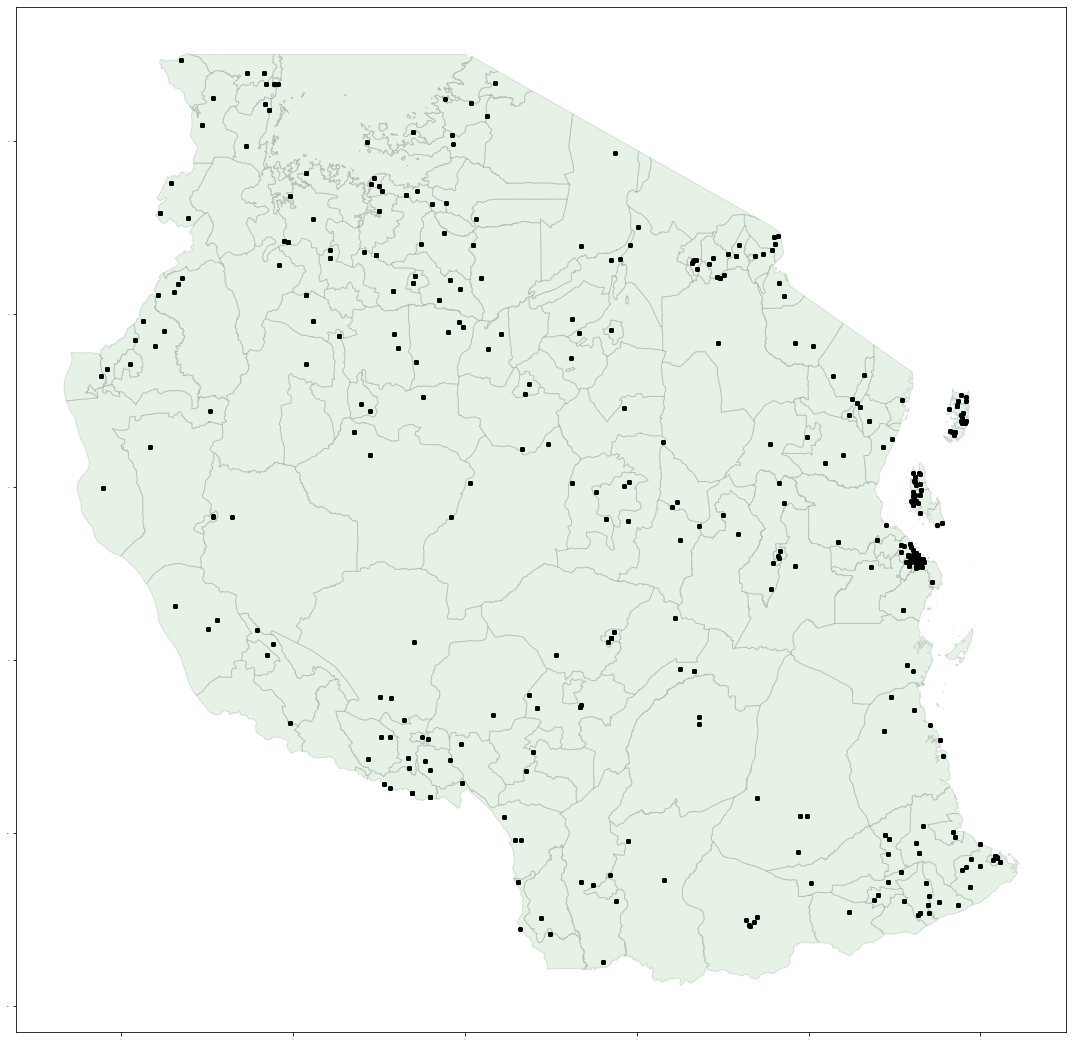

In [70]:
country="TZA"
fig, ax = plt.subplots(1,1,figsize=(15,15))
ax.tick_params(labelsize=0)

ipums_terra.loc[ipums_terra["iso_3"]==country,:].plot(ax=ax, color="green", edgecolor="black", alpha=0.1)
#geo_indicator.loc[geo_indicator["iso_3"]==country,:].plot(ax=ax, marker='o', color='black', markersize=15)
lsms_data.loc[lsms_data["iso_3"]==country,:].plot(ax=ax, marker='o', color="black", markersize=15)
fig.tight_layout()
fig.savefig("./outputs/samples/map_with_lsms.png")